In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [17]:
from sklearn.model_selection import train_test_split

In [1]:
import tensorflow as tf

2024-02-26 17:08:42.125837: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-26 17:08:42.125937: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-26 17:08:42.394974: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Code for Cropping

In [ ]:
import cv2, os, glob
# path to original image folder
data_path = "**"
# path to the folder to save the cropped image
save_path = "**"
imgfiles = glob.iglob(os.path.join(data_path, '**/*.JPG'), recursive=True)
for imgfile in imgfiles:
    image = cv2.imread(imgfile)
    img_name = imgfile.split('/')[-1]
    # Define the coordinates of the top-left and bottom-right points of the cropping rectangle
    # Format: (x, y)
    top_left = (50, 240)  # Example values
    bottom_right = (750, 430)  # Example values

    # Crop the image using array slicing
    # Note: OpenCV images are accessed with (y, x) notation
    cropped_image = image[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]]

    # Save or display the cropped image
    cv2.imwrite(save_path + img_name, cropped_image)
    # or
    # cv2.imshow('Cropped Image', cropped_image)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()

In [2]:
path="/kaggle/input/mmia-pothole-challenge-cropped-images/cropped_data"

In [5]:
train_id=pd.read_csv("/kaggle/input/data-files/train_ids_labels.csv")

In [6]:
train_id

,Image_ID,Label
0,cVOfkSdqnWXUerr,0
1,EhnvIDPXFFjUhkR,0
2,tYKqoStvHsryFhS,1
3,eSpjlsZIwOMLmUS,1
4,uzxhIXjNENLyHwZ,1
...,...,...
4021,HPmIRNZNYnJGtHp,1
4022,tXgGJzdKiOuKOZZ,0
4023,bJNJEzeYfmPTZrm,0
4024,dYyArLoquZIFCTh,1


In [7]:
train_id["Image_ID"]=train_id["Image_ID"]+".JPG"

In [8]:
train_id.Label=train_id["Label"].astype("str")

In [9]:
image_filenames = train_id["Image_ID"].tolist()

In [10]:
demo_image_file_path=path+"/"+train_id["Image_ID"][0]

In [11]:
demo_image_file_path

'/kaggle/input/mmia-pothole-challenge-cropped-images/cropped_data/cVOfkSdqnWXUerr.JPG'

In [12]:
img=tf.keras.utils.load_img(demo_image_file_path)

In [13]:
input_arr = tf.keras.utils.img_to_array(img)

In [14]:
input_arr.shape

(210, 700, 3)

In [18]:
train_df, val_df = train_test_split(train_id, test_size=0.15, random_state=42,stratify=train_id["Label"])

In [19]:
train_datagen=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,rotation_range=40,width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=None,
    shear_range=0.2,
    zoom_range=0.2,
    channel_shift_range=0.2,
    fill_mode='nearest',
    cval=0.2,
    horizontal_flip=True,
    vertical_flip=True)

In [20]:
train_ds=train_datagen.flow_from_dataframe(dataframe=train_df,directory=path,class_mode="binary",y_col="Label",batch_size=32,target_size=(224,224),x_col="Image_ID",shuffle=True)

Found 3422 validated image filenames belonging to 2 classes.


In [21]:
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [22]:
val_ds=val_datagen.flow_from_dataframe(dataframe=val_df,directory=path,class_mode="binary",y_col="Label",batch_size=32,target_size=(224,224),x_col="Image_ID",shuffle=False)

Found 604 validated image filenames belonging to 2 classes.


## Visualizing

In [23]:
x_train, y_train=next(train_ds)

In [24]:
x_val,y_val=next(val_ds)

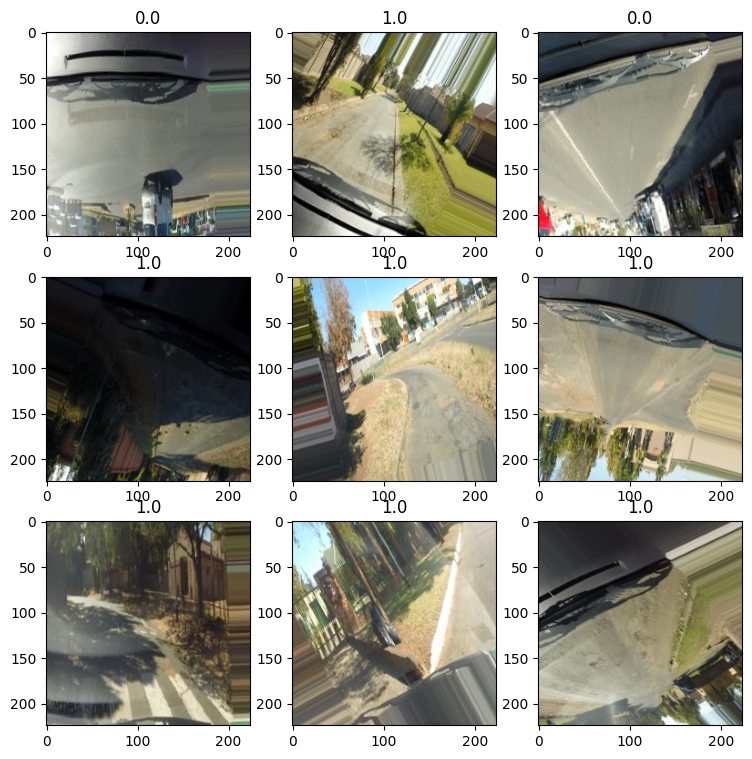

In [25]:
plt.figure(figsize=(9,9))
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.imshow(x_train[i])
  plt.title(y_train[i])  
plt.show()


## Resnet 152V2

In [26]:
base_model = tf.keras.applications.ResNet152V2(weights='imagenet', include_top=False,input_shape=(224, 224, 3))

234545216/234545216 [==============================] - 1s 0us/step


In [52]:
len(base_model.layers)

564

In [27]:
for layer in base_model.layers:
    layer.trainable = False

In [28]:
model = tf.keras.Sequential([ base_model,
    tf.keras.layers.GlobalMaxPooling2D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1,activation="sigmoid")
])

In [29]:
callbacks=tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=20,restore_best_weights=True)

In [30]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=tf.keras.losses.BinaryCrossentropy(),metrics=tf.keras.metrics.AUC(name='AUC'))

In [31]:
epochs = 100
model.fit(train_ds, epochs=epochs, validation_data=val_ds,callbacks=callbacks)

Epoch 1/100


I0000 00:00:1708967472.553944     115 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


107/107 [==============================] - 103s 782ms/step - loss: 0.6818 - AUC: 0.6059 - val_loss: 0.5916 - val_AUC: 0.8389
Epoch 2/100
107/107 [==============================] - 52s 483ms/step - loss: 0.5935 - AUC: 0.7427 - val_loss: 0.5168 - val_AUC: 0.8909
Epoch 3/100
107/107 [==============================] - 51s 475ms/step - loss: 0.5415 - AUC: 0.7949 - val_loss: 0.4548 - val_AUC: 0.9035
Epoch 4/100
107/107 [==============================] - 52s 487ms/step - loss: 0.4787 - AUC: 0.8448 - val_loss: 0.4043 - val_AUC: 0.9131
Epoch 5/100
107/107 [==============================] - 52s 480ms/step - loss: 0.4608 - AUC: 0.8608 - val_loss: 0.3795 - val_AUC: 0.9181
Epoch 6/100
107/107 [==============================] - 51s 478ms/step - loss: 0.4264 - AUC: 0.8834 - val_loss: 0.3780 - val_AUC: 0.9241
Epoch 7/100
107/107 [==============================] - 52s 481ms/step - loss: 0.4223 - AUC: 0.8842 - val_loss: 0.3372 - val_AUC: 0.9340
Epoch 8/100
107/107 [==============================] - 52s 

In [32]:
model.evaluate(val_ds)

19/19 [==============================] - 4s 228ms/step - loss: 0.1606 - AUC: 0.9845


[0.1605834662914276, 0.9844673871994019]

In [33]:
model.evaluate(train_ds)

107/107 [==============================] - 45s 420ms/step - loss: 0.1652 - AUC: 0.9828


[0.16517607867717743, 0.9828139543533325]

## Trainng top 64 layers

In [34]:
for layer in base_model.layers[500:]:
    layer.trainable = True

In [35]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=tf.keras.losses.BinaryCrossentropy(),metrics=tf.keras.metrics.AUC(name='AUC'))
model.fit(train_ds, epochs=epochs, validation_data=val_ds,callbacks=callbacks)

Epoch 1/100
107/107 [==============================] - 77s 522ms/step - loss: 0.2709 - AUC: 0.9545 - val_loss: 0.8623 - val_AUC: 0.9391
Epoch 2/100
107/107 [==============================] - 52s 483ms/step - loss: 0.2136 - AUC: 0.9705 - val_loss: 0.1975 - val_AUC: 0.9830
Epoch 3/100
107/107 [==============================] - 51s 475ms/step - loss: 0.1890 - AUC: 0.9758 - val_loss: 0.1483 - val_AUC: 0.9843
Epoch 4/100
107/107 [==============================] - 51s 473ms/step - loss: 0.1650 - AUC: 0.9827 - val_loss: 0.1329 - val_AUC: 0.9905
Epoch 5/100
107/107 [==============================] - 51s 476ms/step - loss: 0.1601 - AUC: 0.9835 - val_loss: 0.1653 - val_AUC: 0.9857
Epoch 6/100
107/107 [==============================] - 50s 470ms/step - loss: 0.1592 - AUC: 0.9822 - val_loss: 0.1423 - val_AUC: 0.9862
Epoch 7/100
107/107 [==============================] - 51s 473ms/step - loss: 0.1414 - AUC: 0.9857 - val_loss: 0.1327 - val_AUC: 0.9924
Epoch 8/100
107/107 [===========================

## Prediction on Test Dataset

In [36]:
test_id=pd.read_csv("/kaggle/input/data-files/test_ids_only.csv")

In [37]:
test_id

,Image_ID
0,nRhHxqLhDlJsiXc
1,gbSntVovxgHQrmO
2,nqOobGmvgEOiPms
3,oIkPTooLcIbZKlF
4,eSKxsTTJDQzkjgD
...,...
1645,BmSrWvzrriPuQOh
1646,HfXCITRCHqrLOda
1647,uQLYKtTCnvWWGVu
1648,gYWbwjUOZrOlTzQ


In [38]:
test_id["Image_ID2"]=test_id["Image_ID"]+".JPG"

In [39]:
datagen2=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [40]:
test_ds=datagen2.flow_from_dataframe(dataframe=test_id,directory=path,class_mode=None,batch_size=32,target_size=(224,224),x_col="Image_ID2",shuffle=False)

Found 1650 validated image filenames.


In [34]:
x_test=next(test_ds)

In [ ]:
plt.figure(figsize=(9,9))
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.imshow(x_test[i]) 
plt.show()


In [41]:
pred_test=model.predict(test_ds)

52/52 [==============================] - 23s 399ms/step


In [42]:
pred_test

array([[5.9189785e-01],
       [1.5207009e-01],
       [3.8056987e-05],
       ...,
       [9.9997270e-01],
       [2.1117561e-01],
       [9.3170905e-01]], dtype=float32)

In [43]:
pred_test=pd.DataFrame(pred_test,columns=["Label"])

In [44]:
pred_test

,Label
0,0.591898
1,0.152070
2,0.000038
3,0.999780
4,0.754267
...,...
1645,0.000025
1646,0.734624
1647,0.999973
1648,0.211176


In [45]:
pred_test[pred_test["Label"]>0.5]

,Label
0,0.591898
3,0.999780
4,0.754267
5,0.999999
11,0.973531
...,...
1643,0.647177
1644,0.729254
1646,0.734624
1647,0.999973


In [46]:
pred_test["Image_ID"]=test_id["Image_ID"]

In [47]:
pred_test=pred_test.reindex(["Image_ID","Label"],axis=1)

In [48]:
pred_test.to_csv("Target _resent_152_final_effort.csv",index=False)

## Saving the model

In [50]:
model.save_weights('./checkpoints/my_checkpoint')

In [52]:
model.save('Model.keras')